In [1]:
# https://github.com/hhuynh000/EE399_HW5
# Import statements
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

# Plottting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D

# Setting plotting configuration
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

# Solving lorenz equation
from scipy import integrate

# Torch
import torch
import torch.nn as nn
import torch.optim as optim

from simple_esn.simple_esn import SimpleESN

In [2]:
# Set computing device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Neural Network for State Prediction (Lorenz Equations)

In [3]:
# Compute data matrix from lorenz equation &
# plot Lorenz states
def compute_lorenz(config):
    # initialize time range
    t= np.arange(0,config['T'] + config['dt'], config['dt'])
    # initialize X and Y matrix
    x_input = np.zeros((100*(len(t)-1),3))
    y_output = np.zeros_like(x_input)
    
    # generate random initial conditions
    np.random.seed(123)
    x0 = -15 + 30 * np.random.random((100, 3))
    
    # derive Lorenz equation
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])
    
    # plot states
    fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
    for j in range(100):
        x_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
        y_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
        x, y, z = x_t[j,:,:].T
        ax.plot(x, y, z,linewidth=1)
        ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')

    ax.view_init(18, -113)
    plt.show()
    
    return x_input, y_output

In [4]:
# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(in_features=3, out_features=18)
        self.fc2 = nn.Linear(in_features=18, out_features=72)
        self.fc3 = nn.Linear(in_features=72, out_features=3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [5]:
# Define model training
def trainer(model, x_input, y_output, lr, momentum, n_epochs):
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # Convert numpy arrays to PyTorch tensors
    nn_input = torch.from_numpy(x_input).float().to(device)
    nn_output = torch.from_numpy(y_output).float().to(device)

    # Train the model
    for epoch in range(n_epochs):
        loss_record = []
        for j in range(100):
            optimizer.zero_grad()
            outputs = model(nn_input[j*800:(j+1)*800,:])
            loss = criterion(outputs, nn_output[j*800:(j+1)*800,:])
            loss.backward()
            optimizer.step()
            loss_record.append(loss.item())
        print(f"Epoch {epoch+1}, loss={np.mean(loss_record):.4f}")

In [6]:
# Define model validation
def validate(model, x_input, y_output):
    # Convert numpy arrays to PyTorch tensors
    nn_input = torch.from_numpy(x_input).float().to(device)
    mse = []
    outputs = []
    with torch.no_grad():
        for j in range(100):
            output = model(nn_input[j*800:(j+1)*800,:]).cpu()
            outputs.append(output.numpy())
            mse.append(mean_squared_error(y_output[j*800:(j+1)*800,:], output))
    
    print(np.mean(mse))
    return outputs

In [7]:
def plot_outputs(outputs):
    fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

    for j in range(100):
        ax.plot(outputs[j][:,0], outputs[j][:,1], outputs[j][:,2], linewidth=1)

    plt.show()

## Train a NN to advance the solution from t to t + ∆t for ρ = 10, 28, 40

In [8]:
# Lorenz equation parameters
config = {
    'dt': 0.01,                # time increment
    'T': 8,                    # total time
    'beta': 8/3,
    'sigma': 10,
    'rho': 10
}

# Define lorenz equation
def lorenz_deriv(x_y_z, t0, sigma=config['sigma'], beta=config['beta'], rho=config['rho']):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

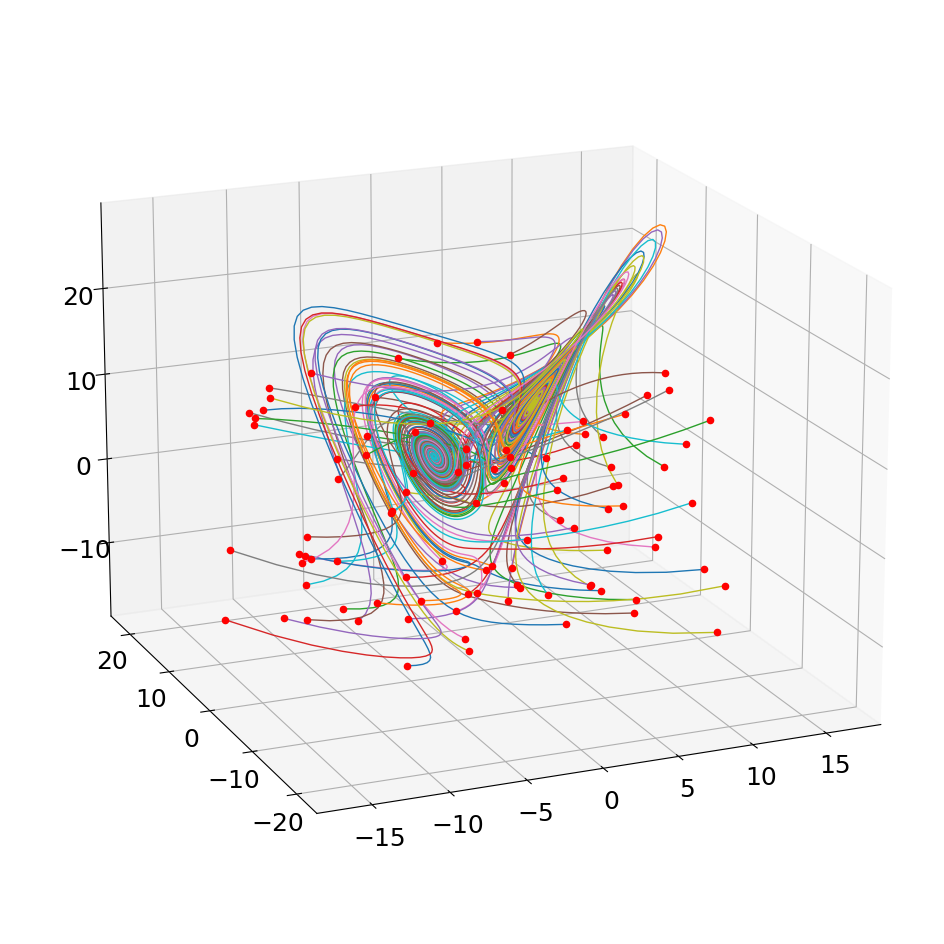

In [9]:
x10_input, y10_output = compute_lorenz(config)

In [10]:
# Lorenz equation parameters
config = {
    'dt': 0.01,                # time increment
    'T': 8,                    # total time
    'beta': 8/3,
    'sigma': 10,
    'rho': 28
}

# Define lorenz equation
def lorenz_deriv(x_y_z, t0, sigma=config['sigma'], beta=config['beta'], rho=config['rho']):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

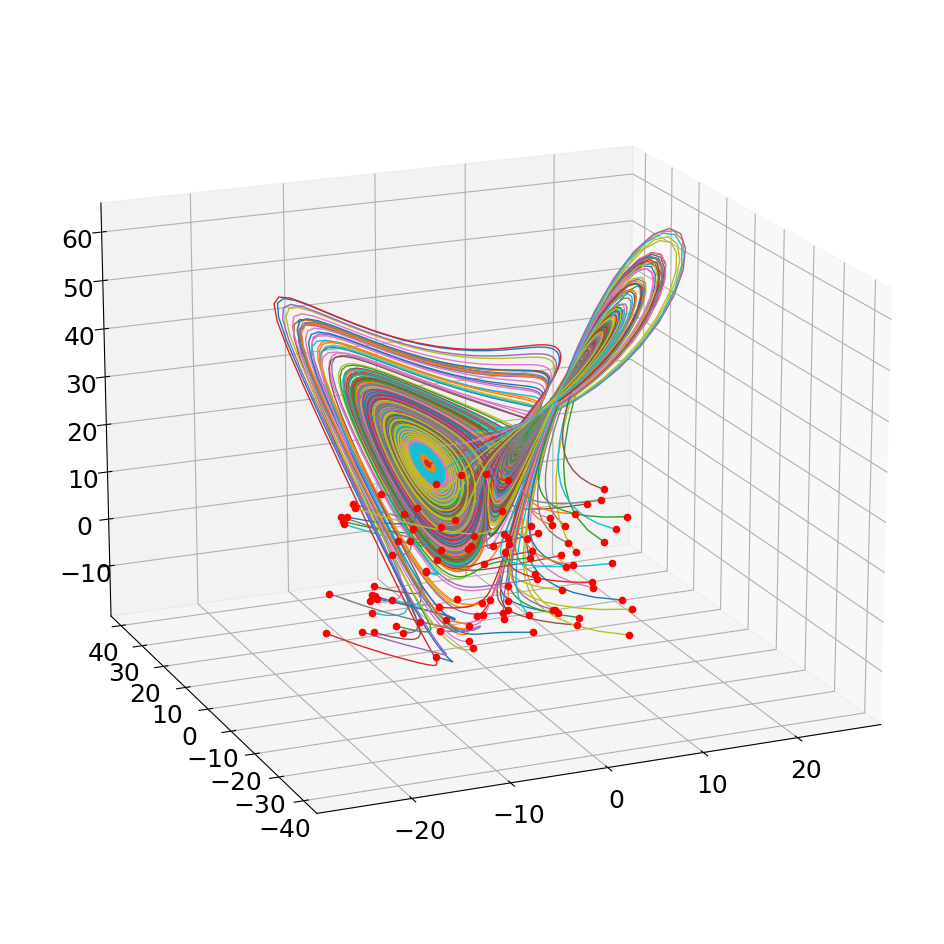

In [11]:
x28_input, y28_output = compute_lorenz(config)

In [12]:
# Lorenz equation parameters
config = {
    'dt': 0.01,                # time increment
    'T': 8,                    # total time
    'beta': 8/3,
    'sigma': 10,
    'rho': 40
}

# Define lorenz equation
def lorenz_deriv(x_y_z, t0, sigma=config['sigma'], beta=config['beta'], rho=config['rho']):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

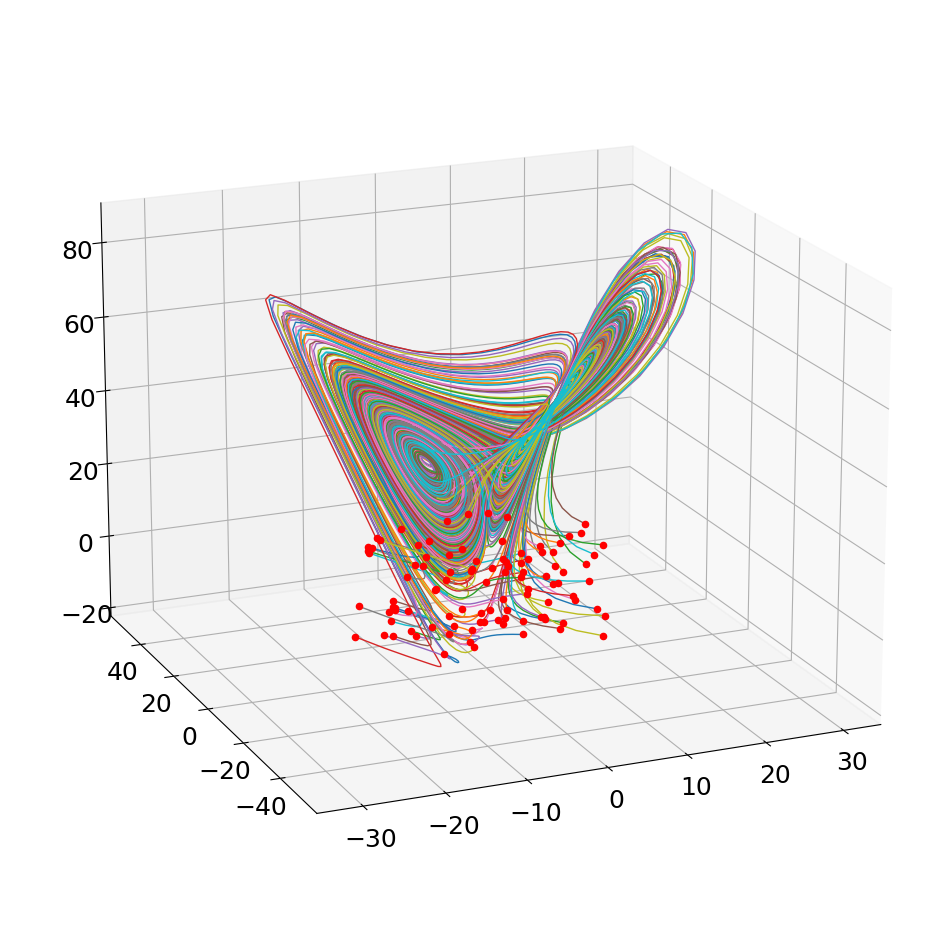

In [13]:
x40_input, y40_output = compute_lorenz(config)

In [14]:
model = MyModel().to(device)

In [15]:
print('Train on rho = 10')
trainer(model, x10_input, y10_output, 0.0001, 0.9, 30)
print('Train on rho = 28')
trainer(model, x28_input, y28_output, 0.0001, 0.9, 30)
print('Train on rho = 40')
trainer(model, x40_input, y40_output, 0.0001, 0.9, 30)

Train on rho = 10
Epoch 1, loss=8.8566
Epoch 2, loss=0.8033
Epoch 3, loss=0.6493
Epoch 4, loss=0.5373
Epoch 5, loss=0.4537
Epoch 6, loss=0.3897
Epoch 7, loss=0.3397
Epoch 8, loss=0.3002
Epoch 9, loss=0.2686
Epoch 10, loss=0.2429
Epoch 11, loss=0.2215
Epoch 12, loss=0.2034
Epoch 13, loss=0.1877
Epoch 14, loss=0.1739
Epoch 15, loss=0.1615
Epoch 16, loss=0.1503
Epoch 17, loss=0.1402
Epoch 18, loss=0.1311
Epoch 19, loss=0.1228
Epoch 20, loss=0.1152
Epoch 21, loss=0.1080
Epoch 22, loss=0.1013
Epoch 23, loss=0.0951
Epoch 24, loss=0.0895
Epoch 25, loss=0.0845
Epoch 26, loss=0.0799
Epoch 27, loss=0.0757
Epoch 28, loss=0.0718
Epoch 29, loss=0.0683
Epoch 30, loss=0.0650
Train on rho = 28
Epoch 1, loss=0.3652
Epoch 2, loss=0.1979
Epoch 3, loss=0.1736
Epoch 4, loss=0.1609
Epoch 5, loss=0.1529
Epoch 6, loss=0.1471
Epoch 7, loss=0.1425
Epoch 8, loss=0.1387
Epoch 9, loss=0.1355
Epoch 10, loss=0.1328
Epoch 11, loss=0.1304
Epoch 12, loss=0.1281
Epoch 13, loss=0.1260
Epoch 14, loss=0.1240
Epoch 15, loss

## Test model on state prediction for ρ = 17, 35

In [16]:
# Lorenz equation parameters
config = {
    'dt': 0.01,                # time increment
    'T': 8,                    # total time
    'beta': 8/3,
    'sigma': 10,
    'rho': 17
}
# Define lorenz equation
def lorenz_deriv(x_y_z, t0, sigma=config['sigma'], beta=config['beta'], rho=config['rho']):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

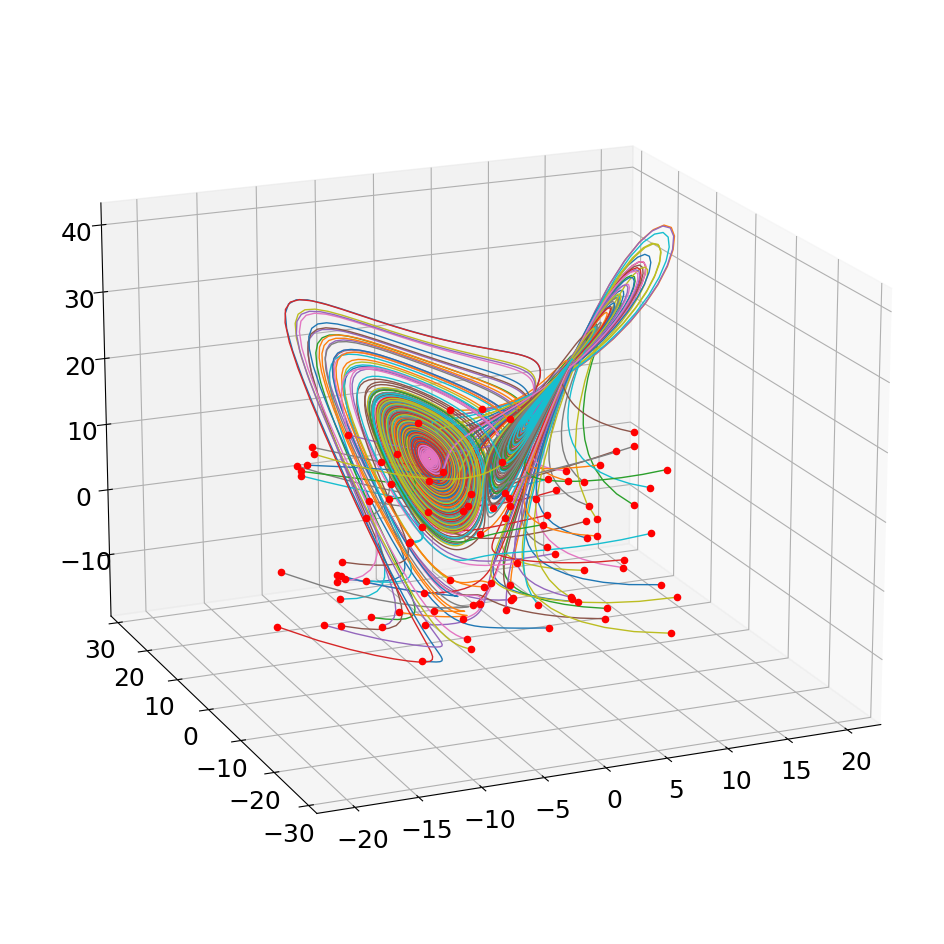

In [17]:
x17_input, y17_output = compute_lorenz(config)

In [18]:
outputs17 = validate(model, x17_input, y17_output)

0.38792273235975844


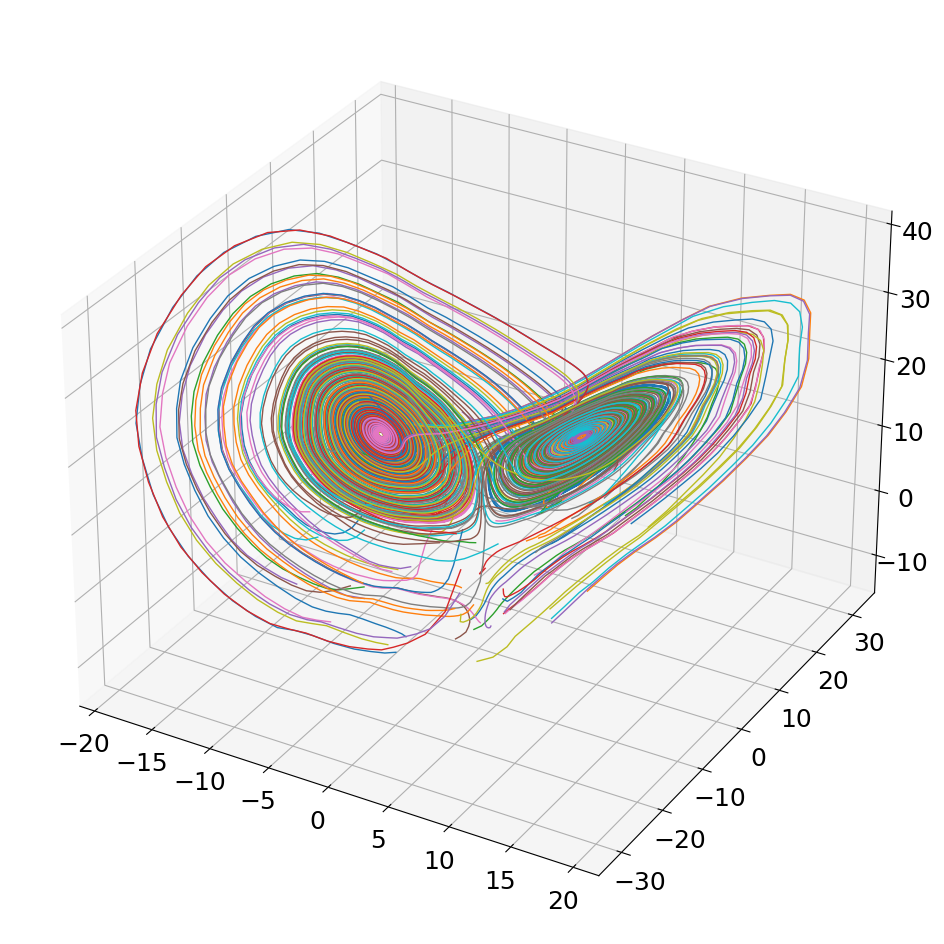

In [19]:
plot_outputs(outputs17)

In [20]:
# Lorenz equation parameters
config = {
    'dt': 0.01,                # time increment
    'T': 8,                    # total time
    'beta': 8/3,
    'sigma': 10,
    'rho': 35
}

# Define lorenz equation
def lorenz_deriv(x_y_z, t0, sigma=config['sigma'], beta=config['beta'], rho=config['rho']):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

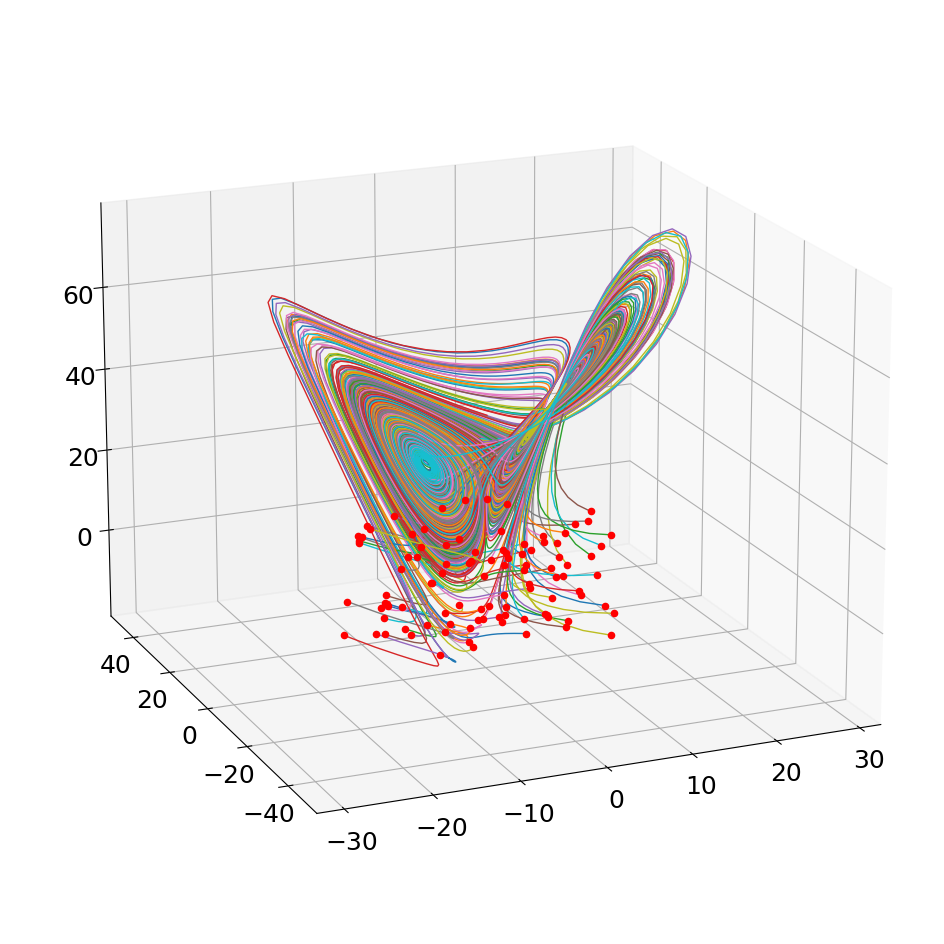

In [21]:
x35_input, y35_output = compute_lorenz(config)

In [22]:
outputs35 = validate(model, x35_input, y35_output)

0.1651750981821019


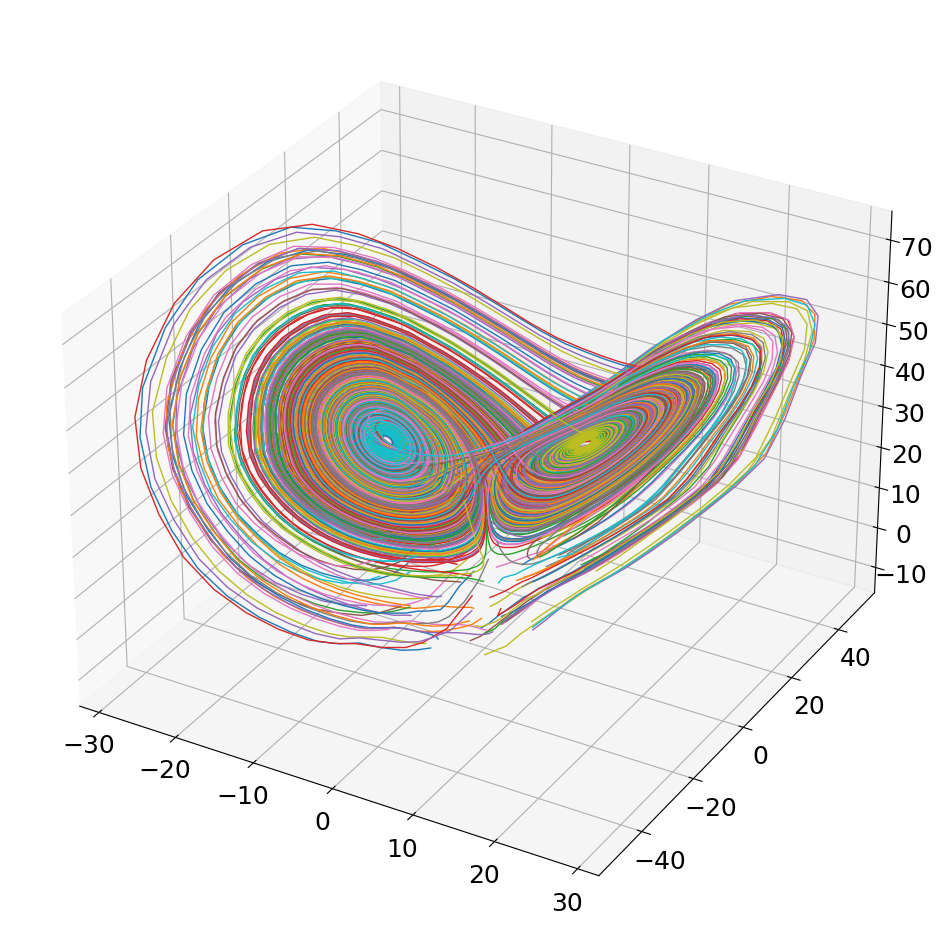

In [23]:
plot_outputs(outputs35)

## Train and test LSTM approach

In [62]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=50, num_layers=3)
        self.fc1 = nn.Linear(in_features=50, out_features=3)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc1(x)

        return x

In [63]:
model = LSTM().to(device)

In [64]:
print('Train on rho = 10')
trainer(model, x10_input, y10_output, 0.001, 0.9, 30)
print('Train on rho = 28')
trainer(model, x28_input, y28_output, 0.001, 0.9, 30)
print('Train on rho = 40')
trainer(model, x40_input, y40_output, 0.001, 0.9, 30)

Train on rho = 10
Epoch 1, loss=27.1237
Epoch 2, loss=6.6493
Epoch 3, loss=2.6550
Epoch 4, loss=1.9992
Epoch 5, loss=1.5951
Epoch 6, loss=1.3258
Epoch 7, loss=1.1403
Epoch 8, loss=0.9707
Epoch 9, loss=0.8153
Epoch 10, loss=0.8742
Epoch 11, loss=0.8015
Epoch 12, loss=0.6408
Epoch 13, loss=0.5903
Epoch 14, loss=0.5626
Epoch 15, loss=0.6394
Epoch 16, loss=0.5761
Epoch 17, loss=0.4792
Epoch 18, loss=0.4346
Epoch 19, loss=0.4052
Epoch 20, loss=0.3931
Epoch 21, loss=0.3864
Epoch 22, loss=0.3629
Epoch 23, loss=0.3335
Epoch 24, loss=0.3248
Epoch 25, loss=0.3064
Epoch 26, loss=0.2983
Epoch 27, loss=0.2831
Epoch 28, loss=0.2684
Epoch 29, loss=0.2592
Epoch 30, loss=0.2592
Train on rho = 28
Epoch 1, loss=35.7255
Epoch 2, loss=21.4916
Epoch 3, loss=12.8682
Epoch 4, loss=9.6596
Epoch 5, loss=6.2286
Epoch 6, loss=4.5052
Epoch 7, loss=2.3437
Epoch 8, loss=2.5979
Epoch 9, loss=1.6612
Epoch 10, loss=1.1517
Epoch 11, loss=0.9760
Epoch 12, loss=0.9839
Epoch 13, loss=0.9065
Epoch 14, loss=0.6894
Epoch 15, 

In [67]:
outputs17 = validate(model, x17_input, y17_output)

142.96302410262996


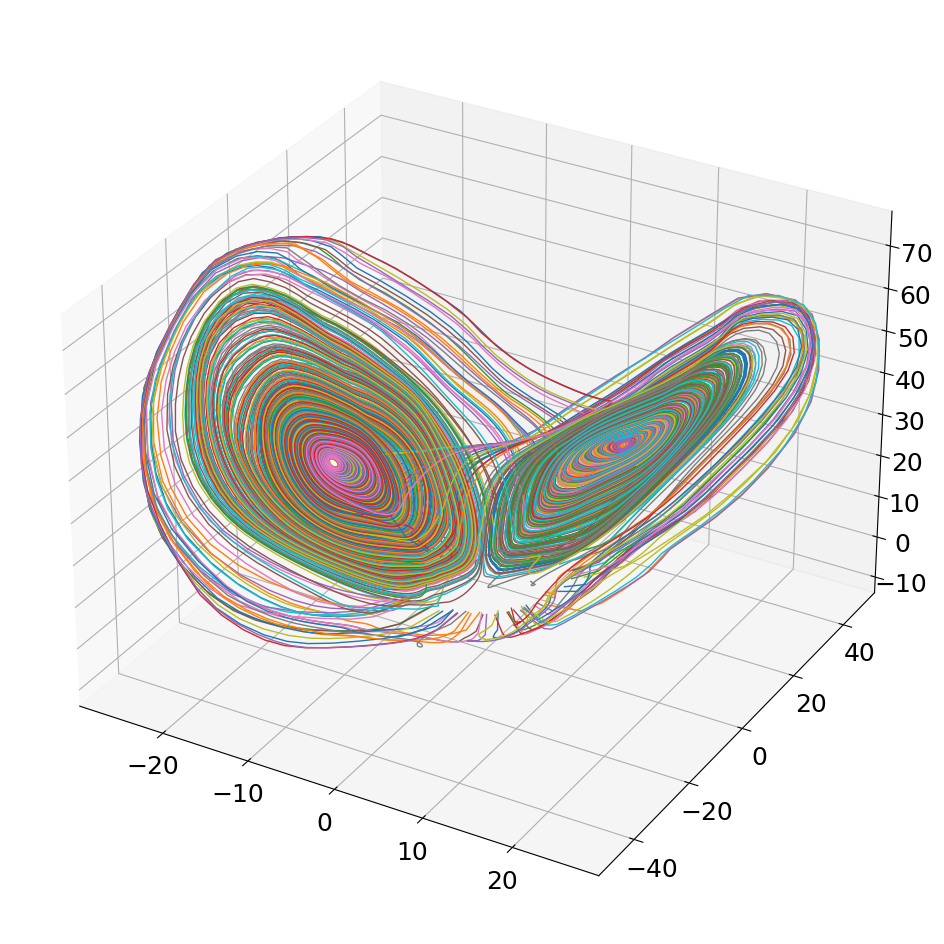

In [69]:
plot_outputs(outputs17)

In [72]:
outputs35 = validate(model, x35_input, y35_output)

9.256416541996634


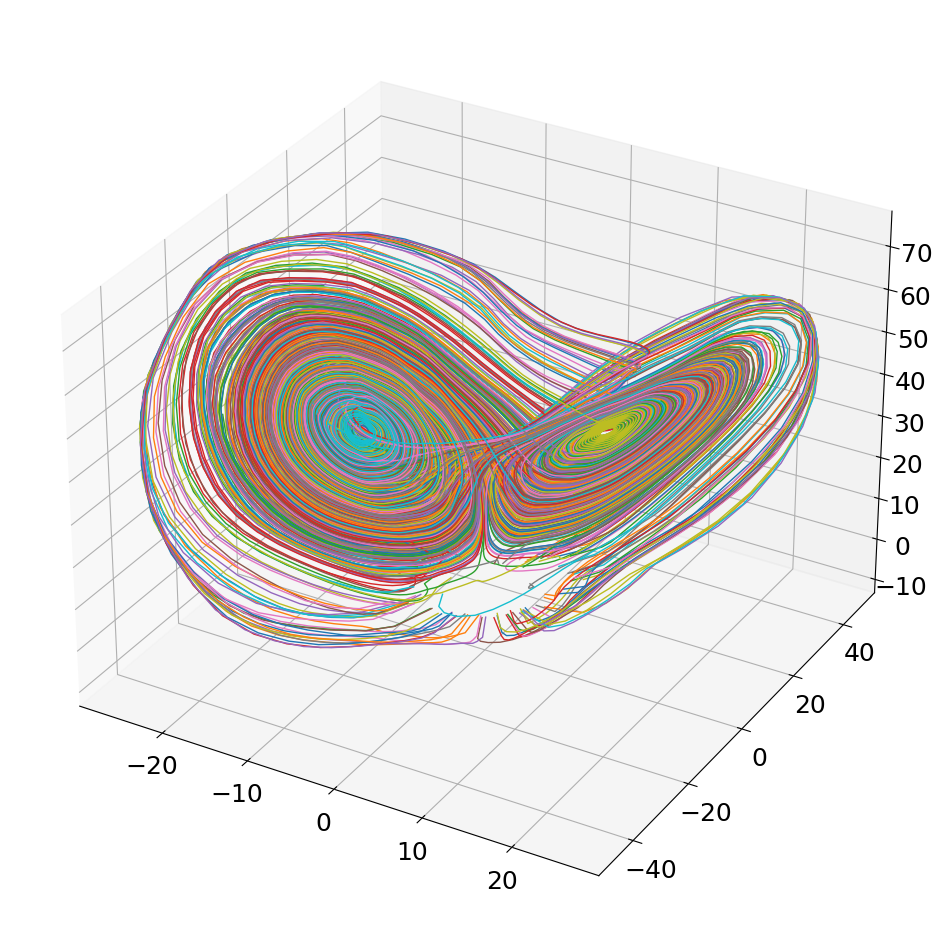

In [73]:
plot_outputs(outputs35)

## Train and test RNN approach

In [74]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=3, hidden_size=50, num_layers=3)
        self.fc1 = nn.Linear(in_features=50, out_features=3)
        
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc1(x)

        return x

In [75]:
model = RNN().to(device)

In [76]:
print('Train on rho = 10')
trainer(model, x10_input, y10_output, 0.001, 0.9, 30)
print('Train on rho = 28')
trainer(model, x28_input, y28_output, 0.001, 0.9, 30)
print('Train on rho = 40')
trainer(model, x40_input, y40_output, 0.001, 0.9, 30)

Train on rho = 10
Epoch 1, loss=9.9072
Epoch 2, loss=1.8877
Epoch 3, loss=1.3221
Epoch 4, loss=0.9937
Epoch 5, loss=0.7984
Epoch 6, loss=0.5831
Epoch 7, loss=0.4722
Epoch 8, loss=0.4370
Epoch 9, loss=0.4847
Epoch 10, loss=0.3199
Epoch 11, loss=0.3244
Epoch 12, loss=0.3330
Epoch 13, loss=0.4050
Epoch 14, loss=0.3071
Epoch 15, loss=0.1968
Epoch 16, loss=0.1892
Epoch 17, loss=0.1730
Epoch 18, loss=0.1726
Epoch 19, loss=0.2539
Epoch 20, loss=0.3317
Epoch 21, loss=0.1503
Epoch 22, loss=0.1149
Epoch 23, loss=0.1088
Epoch 24, loss=0.1304
Epoch 25, loss=0.2323
Epoch 26, loss=0.1072
Epoch 27, loss=0.0934
Epoch 28, loss=0.0903
Epoch 29, loss=0.1060
Epoch 30, loss=0.1738
Train on rho = 28
Epoch 1, loss=29.6060
Epoch 2, loss=24.1345
Epoch 3, loss=19.0094
Epoch 4, loss=20.9851
Epoch 5, loss=22.4681
Epoch 6, loss=21.8492
Epoch 7, loss=15.8961
Epoch 8, loss=13.6743
Epoch 9, loss=14.4820
Epoch 10, loss=16.2248
Epoch 11, loss=16.2600
Epoch 12, loss=14.3858
Epoch 13, loss=12.1424
Epoch 14, loss=8.8594
E

In [80]:
outputs17 = validate(model, x17_input, y17_output)

14.251986522286108


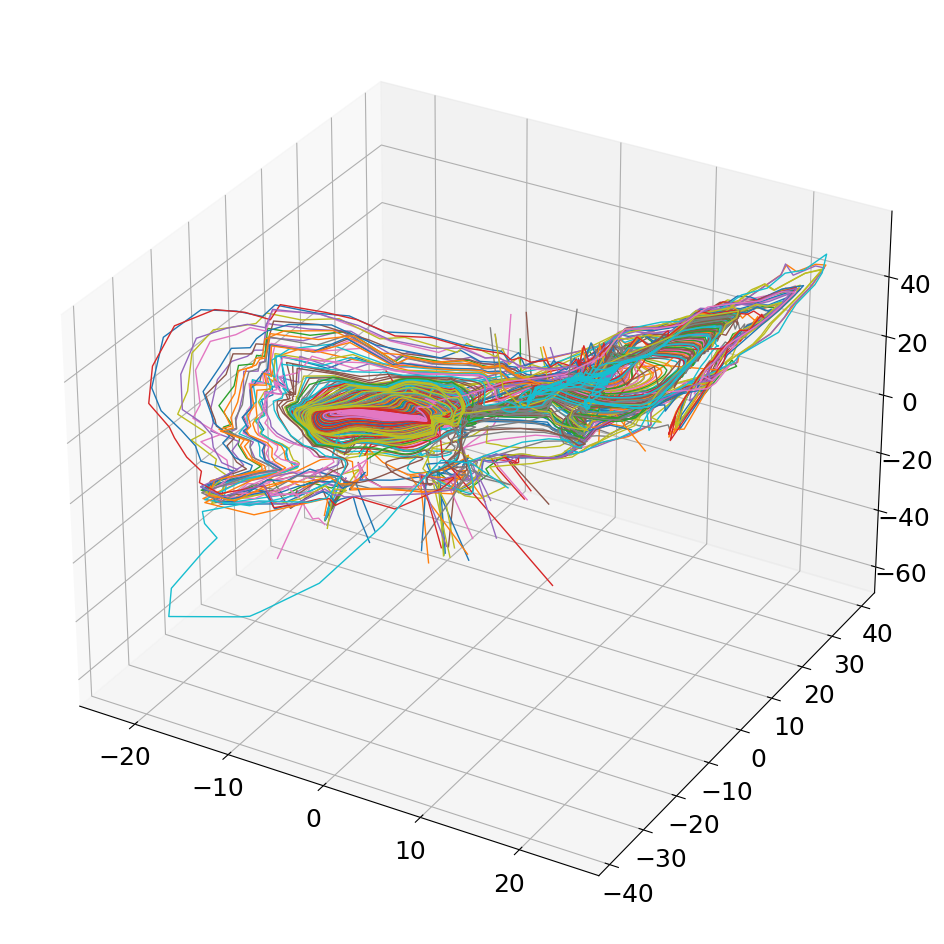

In [81]:
plot_outputs(outputs17)

In [82]:
outputs35 = validate(model, x35_input, y35_output)

2.559850458526826


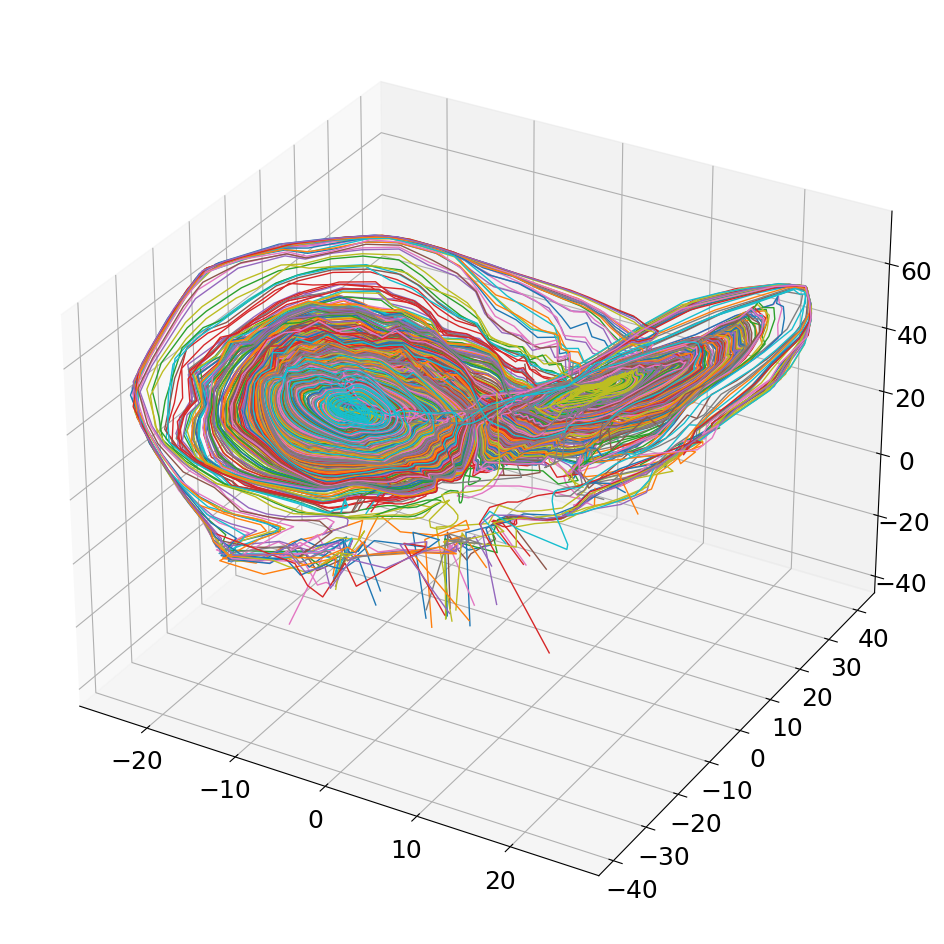

In [83]:
plot_outputs(outputs35)

## Train and test Echo State Networks

In [38]:
 my_esn = SimpleESN(n_readout=1000, n_components=1000,
                       damping=0.3, weight_scaling=1.25)

In [39]:
X_train = np.vstack((x10_input, x28_input, x40_input))
echo_train = my_esn.fit_transform(X_train)

In [40]:
y_train = np.vstack((y10_output, y28_output, y40_output))
regr = Ridge(alpha=0.01)
regr.fit(echo_train, y_train)

Ridge(alpha=0.01)

In [41]:
echo_test = my_esn.transform(x17_input)

In [42]:
y_true, y_pred = y17_output, regr.predict(echo_test)
err = mean_squared_error(y_true, y_pred)
print(err)

1.2881411360166917


In [43]:
y_pred = y_pred.reshape(100, 800, 3)

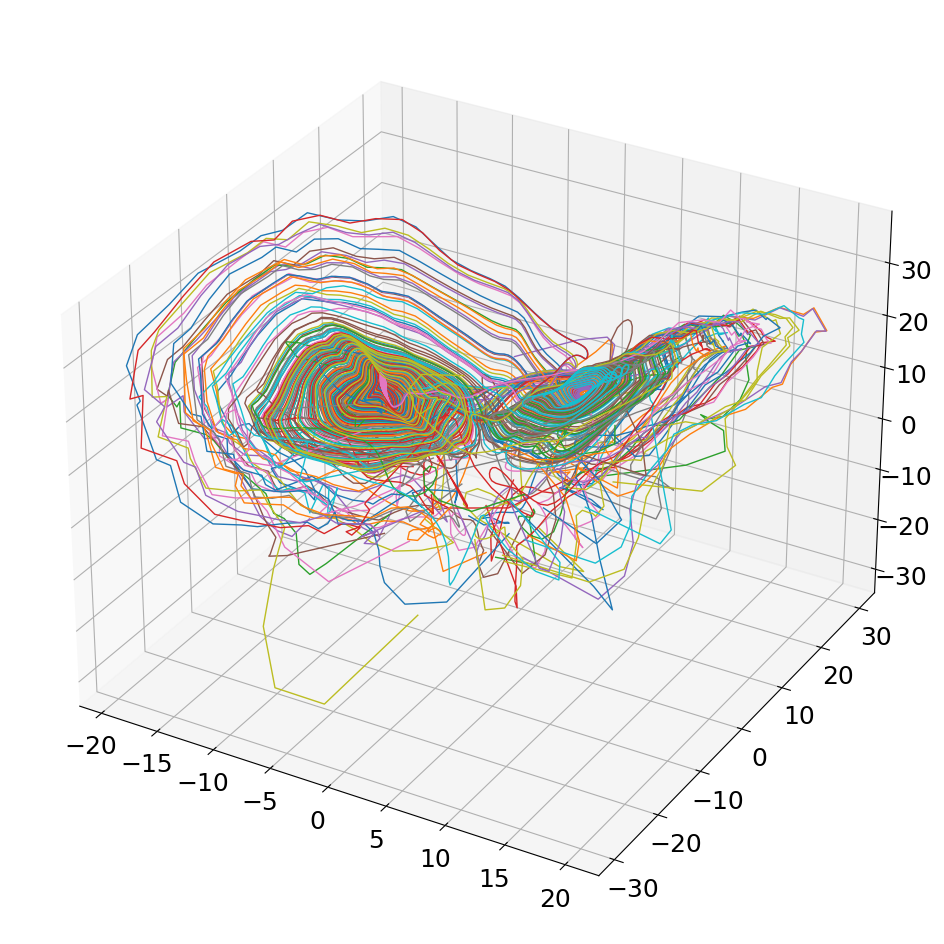

In [44]:
plot_outputs(y_pred)

In [45]:
echo_test = my_esn.transform(x35_input)

In [46]:
y_true, y_pred = y35_output, regr.predict(echo_test)
err = mean_squared_error(y_true, y_pred)
print(err)

0.41823397791358713


In [47]:
y_pred = y_pred.reshape(100, 800, 3)

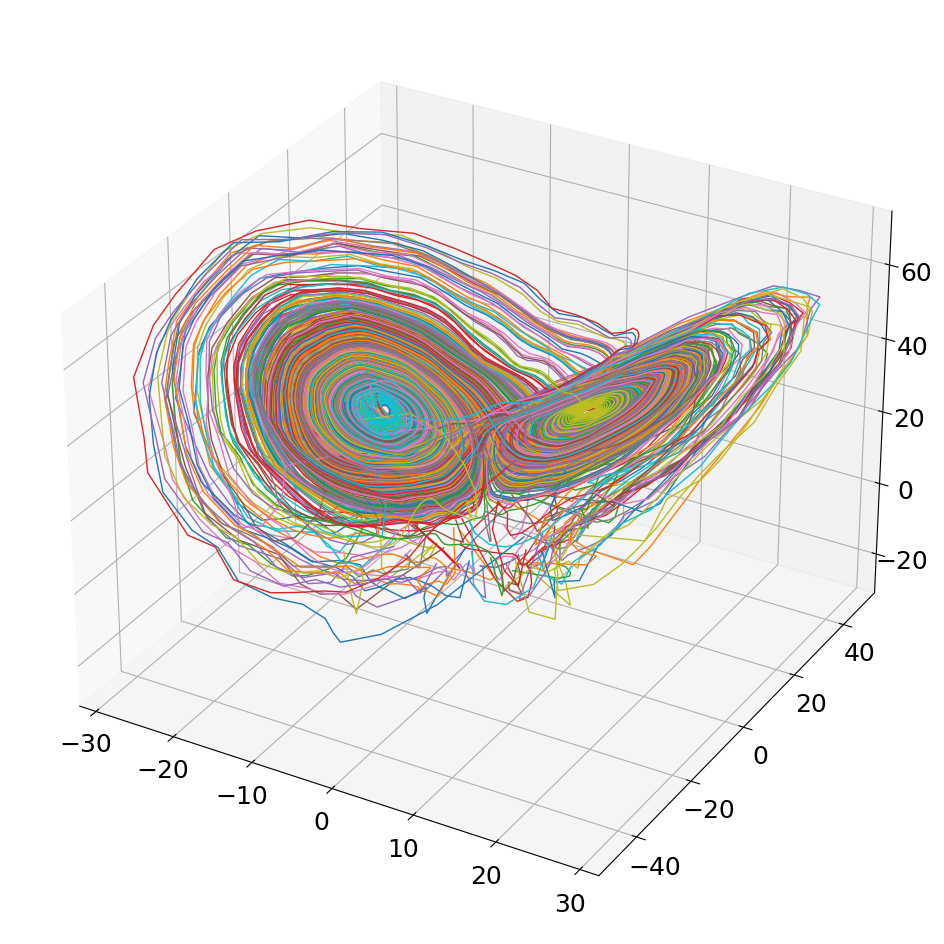

In [48]:
plot_outputs(y_pred)